# Practica 1
**Tecnologías de Lenguaje Natural**

*Luis Fernando Rodríguez Domínguez*

5BV1

*Ingeniería en Inteligencia Artificial*

Fecha última de modificación: 13 de marzo del 2025

## Parte 2. Normalización de Textos

Los textos en español e inglés a analizar y procesar son los incluidos en el Anexo B y deben ser guardados en dos archivos, uno por cada documento, para ser leídos y cargados en memoria desde el programa a desarrollar.

### 1. **Investigación**:

En este estudio se realiza una comparación exhaustiva de tres módulos de procesamiento de lenguaje natural en Python – NLTK, spaCy y Stanza – orientados a la tokenización de textos en inglés y español. Se evalúan las capacidades de cada herramienta en términos de resultados de tokenización (número total de tokens, tokens únicos y frecuencia de tokens) y rendimiento temporal. La investigación busca identificar las diferencias funcionales y de performance entre los módulos, justificando su elección para el análisis de corpus en distintos idiomas. Los resultados obtenidos se analizan mediante histogramas y gráficos comparativos, proporcionando una visión integral de las ventajas y limitaciones de cada enfoque para tareas de análisis exploratorio en textos.

### 2. Análisis exploratorio de texto

In [27]:
# !pip install spacy stanza
# !spacy download en
# !spacy download es

In [28]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

#### Imports y utils para más adelante en el código

In [29]:

import time, re, string
import matplotlib.pyplot as plt
from collections import Counter

# Función para medir tiempo de ejecución de un pipeline
def timed_process(process_func, text):
    inicio = time.time()
    tokens = process_func(text)
    tiempo = time.time() - inicio
    return tiempo, tokens

# Función para cargar un archivo de texto
def load_text(path, encoding='utf-8'):
    with open(path, 'r', encoding=encoding) as file:
        return file.read()

# Función para graficar los 15 tokens más frecuentes
def plot_top_tokens(frequency, title, rotation=45):
    top15 = frequency.most_common(15)
    if top15:
        tokens, counts = zip(*top15)
        plt.style.use('dark_background')
        colors = plt.get_cmap('tab10').colors  # Utiliza la misma paleta
        plt.figure(figsize=(10, 5))
        bars = plt.bar(tokens, counts, color=[colors[i % len(colors)] for i in range(len(tokens))])
        plt.title(title)
        plt.xticks(rotation=rotation, ha="right")
        plt.ylabel("Frecuencia")
        plt.tight_layout()
        plt.show()
    else:
        print("No hay tokens para graficar.")

# Función para graficar comparaciones (barras)
def plot_comparison(modulos, metric, title, ylabel):
    plt.style.use('dark_background')
    colors = plt.get_cmap('tab10').colors
    plt.figure(figsize=(8, 5))
    for i, m in enumerate(modulos):
        plt.bar(m, metric[i], color=colors[i % len(colors)])
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

#### Preparación de los Módulos NLP

Se descargan e inicializan los modelos para cada módulo (NLTK, spaCy y Stanza) para inglés y español.
Se utiliza la misma función de tokenización en cada caso para facilitar la comparación.

##### Inglés

In [30]:
# --- NLTK ---
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

stop_words_en = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# --- spaCy ---
import spacy
nlp_en = spacy.load("en_core_web_sm")

# --- Stanza ---
import stanza
stanza.download('en', verbose=False)
nlp_stanza = stanza.Pipeline('en', processors='tokenize,lemma', verbose=False)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##### Español

In [31]:
# --- NLTK ---
stop_words_es = set(stopwords.words('spanish'))
from nltk.stem import SnowballStemmer
stemmer_es = SnowballStemmer('spanish')

# --- spaCy ---
try:
    nlp_es = spacy.load("es_core_news_sm")
except OSError:
    raise Exception("El modelo 'es_core_news_sm' para spaCy no está instalado.")

# --- Stanza ---
stanza.download('es', verbose=False)
nlp_stanza_es = stanza.Pipeline('es', processors='tokenize,lemma', verbose=False)


A continuación se presenta el contenido para la parte de normalización de textos en inglés utilizando tres módulos (NLTK, spaCy y Stanza). Se incluyen funciones para realizar un pipeline de normalización que ejecuta al menos 6 tareas:  
1. Conversión a minúsculas (Adicional)
2. Remoción de dígitos (Adicional)  
3. Remoción de puntuación (Adicional, dependiendo el modulo es lo mismo que stop words)
4. Tokenización (definida en la práctica)  
5. Remoción de “stop words” (definida en la práctica)
6. Aplicación de stemming y lematización  (definida en la práctica)
7. Filtrado de tokens no alfabéticos y de longitud inferior a 3 caracteres  (Adicional)

El orden de ejecución se justifica de la siguiente forma:  
- Primero se normaliza el texto a minúsculas y se eliminan caracteres no alfabéticos (números y puntuación) para homogeneizar la entrada.  
- Luego se tokeniza para trabajar con unidades lingüísticas.  
- La eliminación de “stop words” reduce ruido en el análisis posterior.  
- Se aplican técnicas de stemming y lematización para reducir la variabilidad léxica.  
- Finalmente, se realiza un filtrado adicional para eliminar tokens cortos o irrelevantes.  

Esta secuencia garantiza que cada paso se aplique sobre un texto ya “limpio” y homogéneo, lo que mejora la calidad y consistencia de la normalización.  
A continuación se presenta el abstract en Markdown y el código correspondiente para la normalización con cada módulo, junto con la comparación de resultados y tiempos.

---

## Resumen del Enfoque

- **Pipeline de Normalización:**  
  Cada módulo sigue una serie de pasos para homogeneizar el texto: se transforma a minúsculas, se eliminan dígitos y puntuación, se tokeniza, se eliminan stop words, se aplica stemming y lematización, y finalmente se filtran tokens irrelevantes.  
- **Justificación del Orden:**  
  La conversión a minúsculas y la eliminación de caracteres no deseados garantizan una base homogénea. La tokenización permite trabajar a nivel de palabra. La remoción de stop words reduce el ruido y las técnicas de stemming y lematización minimizan la variabilidad léxica. Los filtros adicionales aseguran la relevancia de los tokens resultantes.  
- **Comparación y Visualización:**  
  Se miden tiempos de ejecución y se comparan métricas (total y tokens únicos), lo que permite evaluar tanto la calidad de la normalización como el rendimiento de cada módulo.

#### Pipeline Inglés

In [32]:
# --- Tokenización simple ---
def nltk_tokenizer_en(text):
    return word_tokenize(text)

def spacy_tokenizer_en(text):
    doc = nlp_en(text)
    return [token.text for token in doc]

def stanza_tokenizer_en(text):
    doc = nlp_stanza(text)
    tokens = [token.text for sentence in doc.sentences for token in sentence.tokens]
    return tokens

# --- Normalización ---
def normalize_nltk_en(text):
    text = text.lower()
    text = re.sub(r'[\d]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words_en]
    tokens = [ps.stem(t) for t in tokens]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    tokens = [t for t in tokens if t.isalpha() and len(t) >= 3]
    return tokens

def normalize_spacy_en(text):
    text = text.lower()
    doc = nlp_en(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    tokens = [t for t in tokens if len(t) >= 3]
    return tokens

def normalize_stanza_en(text):
    text = text.lower()
    text = re.sub(r'[\d]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    doc = nlp_stanza(text)
    tokens = [word.lemma for sentence in doc.sentences for word in sentence.words]
    tokens = [t for t in tokens if t not in stop_words_en]
    tokens = [ps.stem(t) for t in tokens]
    tokens = [t for t in tokens if t.isalpha() and len(t) >= 3]
    return tokens

#### Pipeline Español

In [33]:
# --- Tokenización simple ---
def nltk_tokenizer_es(text):
    return word_tokenize(text, language='spanish')

def spacy_tokenizer_es(text):
    doc = nlp_es(text)
    return [token.text for token in doc]

def stanza_tokenizer_es(text):
    doc = nlp_stanza_es(text)
    tokens = [token.text for sentence in doc.sentences for token in sentence.tokens]
    return tokens

# --- Normalización ---
def normalize_nltk_es(text):
    text = text.lower()
    text = re.sub(r'[\d]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = nltk_tokenizer_es(text)
    tokens = [t for t in tokens if t not in stop_words_es]
    tokens = [stemmer_es.stem(t) for t in tokens]
    tokens = [t for t in tokens if t.isalpha() and len(t) >= 3]
    return tokens

def normalize_spacy_es(text):
    text = text.lower()
    doc = nlp_es(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    tokens = [t for t in tokens if len(t) >= 3]
    return tokens

def normalize_stanza_es(text):
    text = text.lower()
    text = re.sub(r'[\d]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    doc = nlp_stanza_es(text)
    tokens = [word.lemma for sentence in doc.sentences for word in sentence.words]
    tokens = [t for t in tokens if t not in stop_words_es]
    tokens = [stemmer_es.stem(t) for t in tokens]
    tokens = [t for t in tokens if t.isalpha() and len(t) >= 3]
    return tokens

### Ejecución y Comparación de Resultados

Se procesa un texto de ejemplo (para inglés y para español) utilizando cada módulo tanto para tokenización (análisis exploratorio) como para normalización.  
Luego se muestran los tiempos de procesamiento, total de tokens, tokens únicos y se generan histogramas comparativos.

#### Ejecución Inglés

In [34]:
ruta_texto_en = '/content/AnexoBEnglish.txt'
texto_en = load_text(ruta_texto_en)

# Procesamiento exploratorio (tokenización)
procesos_en = {
    'NLTK': nltk_tokenizer_en,
    'spaCy': spacy_tokenizer_en,
    'Stanza': stanza_tokenizer_en
}
resultados_ex_en = {}
for modulo, func in procesos_en.items():
    tiempo, tokens = timed_process(func, texto_en)
    resultados_ex_en[modulo] = {'tiempo': tiempo, 'total': len(tokens),
                                'unicos': len(set(tokens)), 'frecuencia': Counter(tokens)}
    print(f"{modulo} - Tokenización: {tiempo:.4f} s, Total tokens: {len(tokens)}, Tokens únicos: {len(set(tokens))}")

# Procesamiento de normalización
procesos_norm_en = {
    'NLTK': normalize_nltk_en,
    'spaCy': normalize_spacy_en,
    'Stanza': normalize_stanza_en
}
resultados_norm_en = {}
for modulo, func in procesos_norm_en.items():
    tiempo, tokens = timed_process(func, texto_en)
    resultados_norm_en[modulo] = {'tiempo': tiempo, 'total': len(tokens),
                                  'unicos': len(set(tokens)), 'frecuencia': Counter(tokens)}
    print(f"{modulo} - Normalización: {tiempo:.4f} s, Total tokens: {len(tokens)}, Tokens únicos: {len(set(tokens))}")


NLTK - Tokenización: 0.0021 s, Total tokens: 374, Tokens únicos: 212
spaCy - Tokenización: 0.0914 s, Total tokens: 381, Tokens únicos: 216
Stanza - Tokenización: 0.0974 s, Total tokens: 374, Tokens únicos: 215
NLTK - Normalización: 0.0054 s, Total tokens: 172, Tokens únicos: 136
spaCy - Normalización: 0.0657 s, Total tokens: 160, Tokens únicos: 119
Stanza - Normalización: 0.0951 s, Total tokens: 171, Tokens únicos: 133


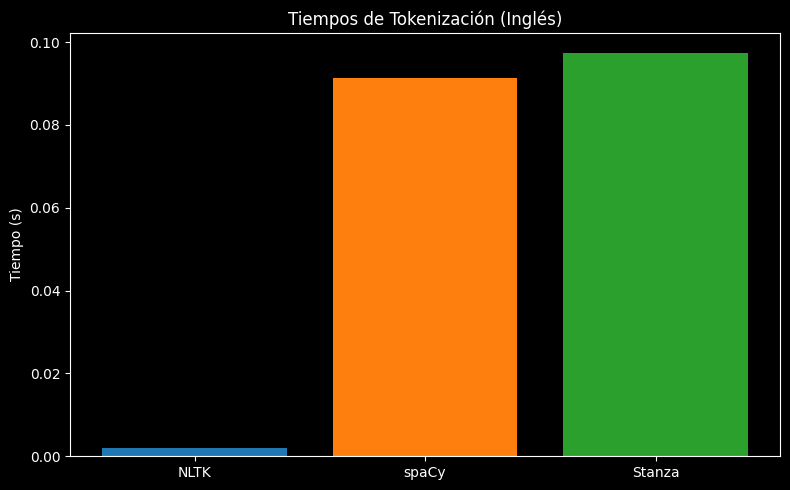

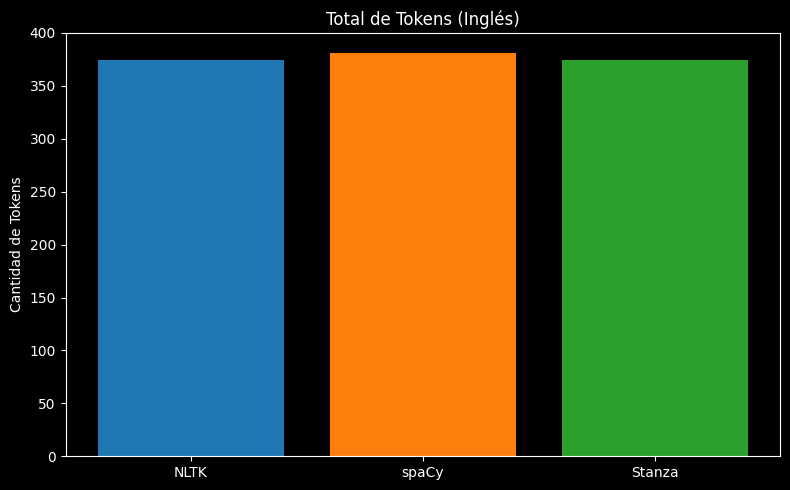

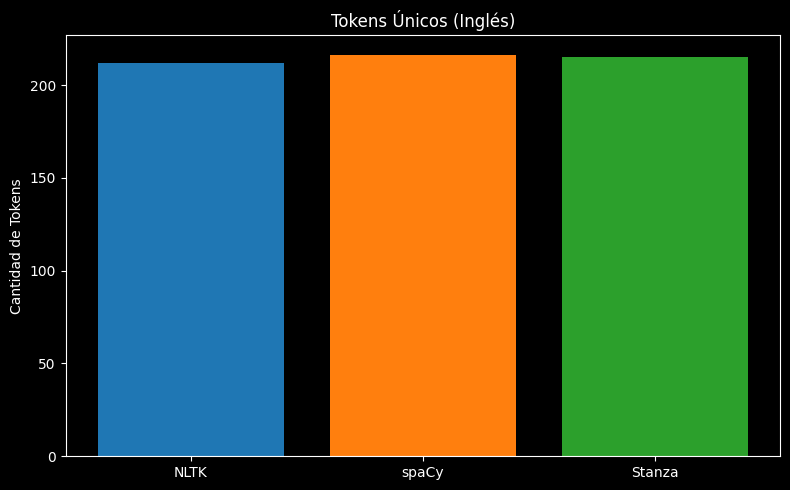

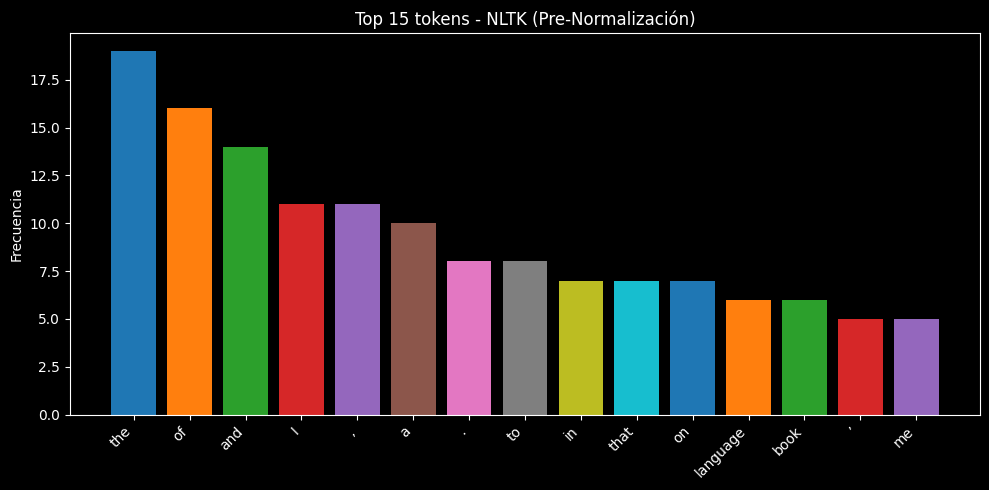

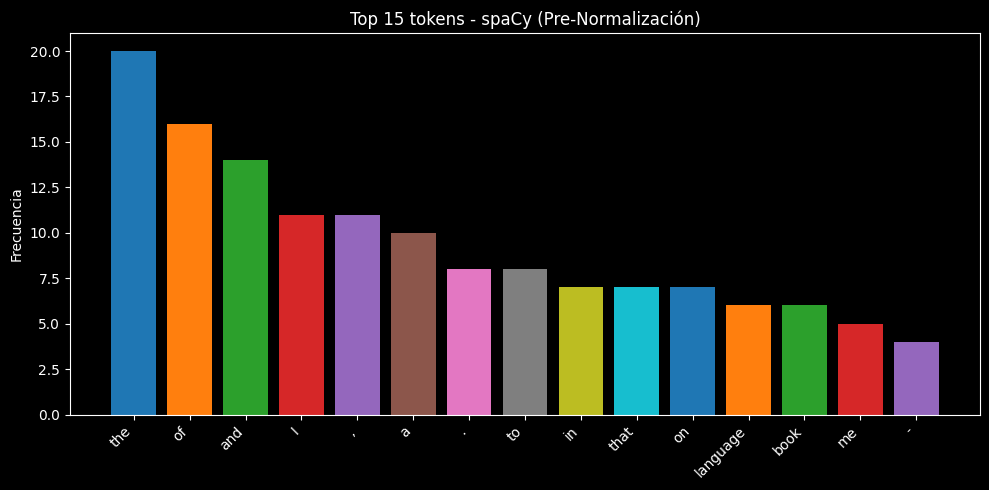

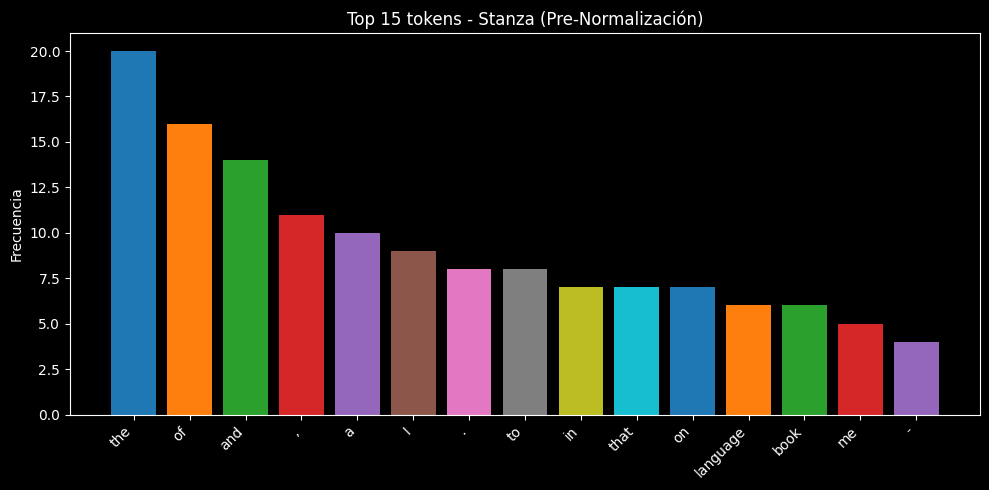

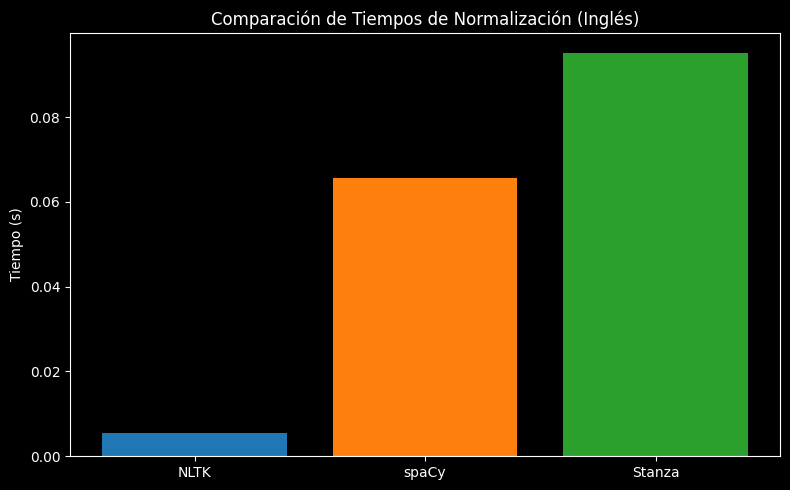

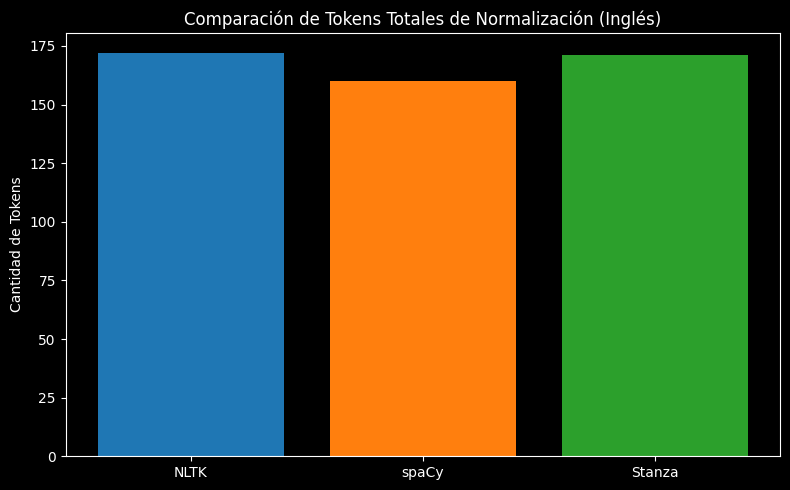

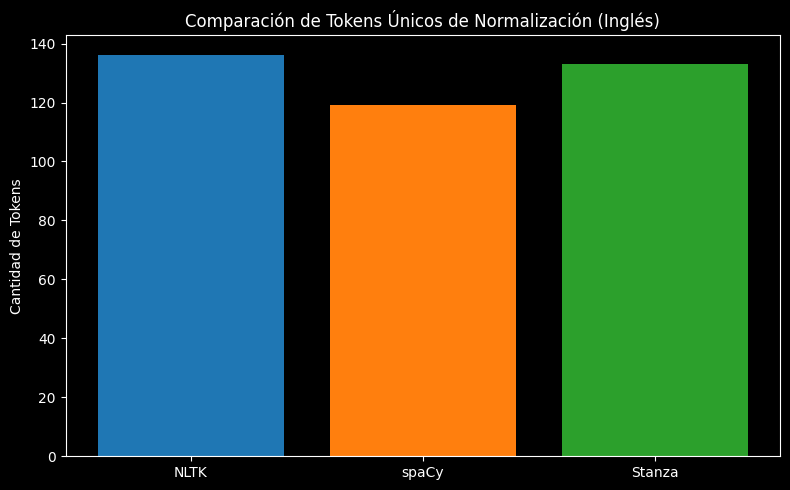

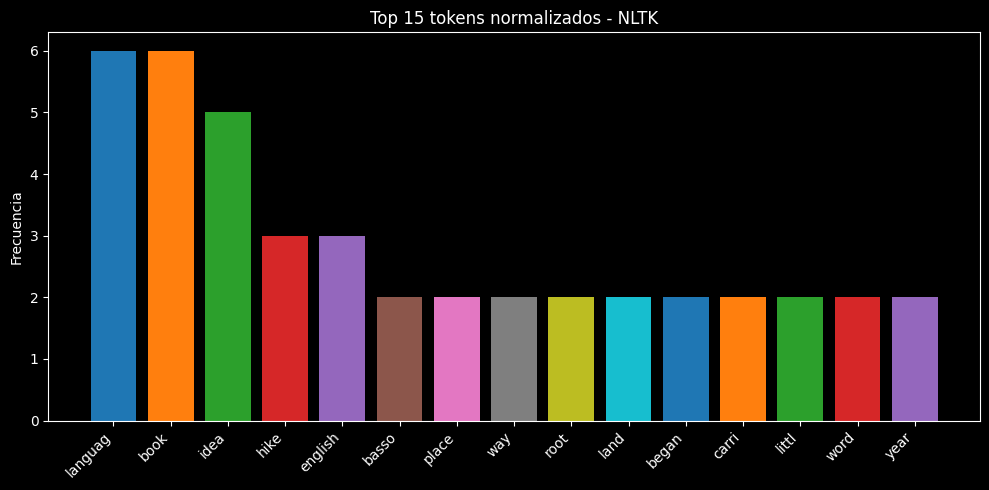

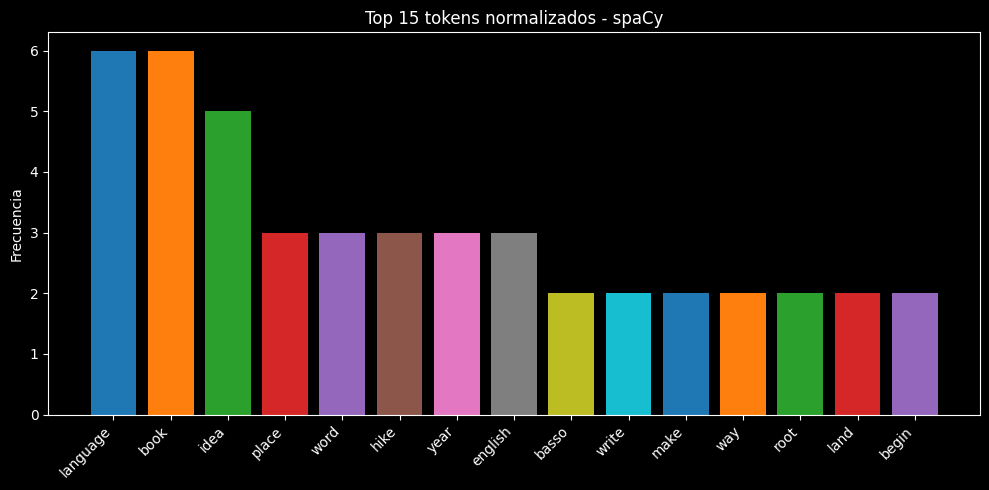

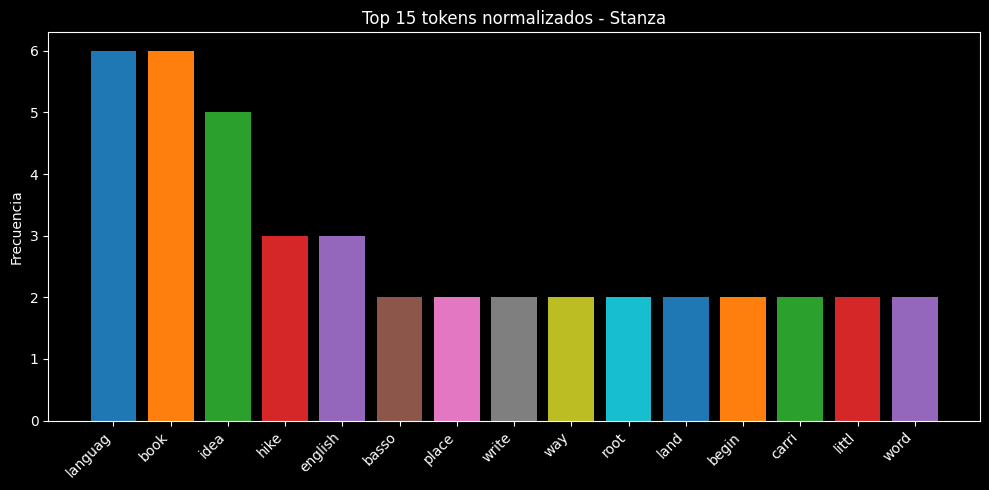

In [35]:
modulos = list(resultados_ex_en.keys())

# Comparación de tiempos (tokenización)
plot_comparison(modulos, [resultados_ex_en[m]['tiempo'] for m in modulos],
                "Tiempos de Tokenización (Inglés)", "Tiempo (s)")
# Comparación de tokens totales (tokenización)
plot_comparison(modulos, [resultados_ex_en[m]['total'] for m in modulos],
                "Total de Tokens (Inglés)", "Cantidad de Tokens")
# Comparación de tokens únicos (tokenización)
plot_comparison(modulos, [resultados_ex_en[m]['unicos'] for m in modulos],
                "Tokens Únicos (Inglés)", "Cantidad de Tokens")
# Tras procesar el texto en inglés (Tokenización)
for modulo in procesos_en.keys():
    plot_top_tokens(resultados_ex_en[modulo]['frecuencia'],
                    f"Top 15 tokens - {modulo} (Pre-Normalización)")


# Comparación de tiempos de normalización para inglés
plot_comparison(modulos, [resultados_norm_en[m]['tiempo'] for m in modulos],
                "Comparación de Tiempos de Normalización (Inglés)", "Tiempo (s)")
# Comparación de tokens totales de normalización para inglés
plot_comparison(modulos, [resultados_norm_en[m]['total'] for m in modulos],
                "Comparación de Tokens Totales de Normalización (Inglés)", "Cantidad de Tokens")
# Comparación de tokens únicos de normalización para inglés
plot_comparison(modulos, [resultados_norm_en[m]['unicos'] for m in modulos],
                "Comparación de Tokens Únicos de Normalización (Inglés)", "Cantidad de Tokens")

# Graficar top tokens normalizados (puedes repetir para cada módulo)
for modulo in modulos:
    plot_top_tokens(resultados_norm_en[modulo]['frecuencia'],
                    f"Top 15 tokens normalizados - {modulo}")

#### Ejecución Español

In [36]:
ruta_texto_es = '/content/AnexoBSpanish.txt'
texto_es = load_text(ruta_texto_es)

# Procesamiento exploratorio (tokenización) para español
procesos_es = {
    'NLTK': nltk_tokenizer_es,
    'spaCy': spacy_tokenizer_es,
    'Stanza': stanza_tokenizer_es
}
resultados_ex_es = {}
for modulo, func in procesos_es.items():
    tiempo, tokens = timed_process(func, texto_es)
    resultados_ex_es[modulo] = {'tiempo': tiempo, 'total': len(tokens),
                                'unicos': len(set(tokens)), 'frecuencia': Counter(tokens)}
    print(f"{modulo} (Español) - Tokenización: {tiempo:.4f} s, Total tokens: {len(tokens)}, Tokens únicos: {len(set(tokens))}")

# Procesamiento de normalización para español
procesos_norm_es = {
    'NLTK': normalize_nltk_es,
    'spaCy': normalize_spacy_es,
    'Stanza': normalize_stanza_es
}
resultados_norm_es = {}
for modulo, func in procesos_norm_es.items():
    tiempo, tokens = timed_process(func, texto_es)
    resultados_norm_es[modulo] = {'tiempo': tiempo, 'total': len(tokens),
                                  'unicos': len(set(tokens)), 'frecuencia': Counter(tokens)}
    print(f"{modulo} (Español) - Normalización: {tiempo:.4f} s, Total tokens: {len(tokens)}, Tokens únicos: {len(set(tokens))}")

NLTK (Español) - Tokenización: 0.0038 s, Total tokens: 373, Tokens únicos: 195
spaCy (Español) - Tokenización: 0.0781 s, Total tokens: 377, Tokens únicos: 198
Stanza (Español) - Tokenización: 0.1563 s, Total tokens: 370, Tokens únicos: 196
NLTK (Español) - Normalización: 0.0042 s, Total tokens: 158, Tokens únicos: 124
spaCy (Español) - Normalización: 0.0511 s, Total tokens: 135, Tokens únicos: 110
Stanza (Español) - Normalización: 0.1606 s, Total tokens: 172, Tokens únicos: 126


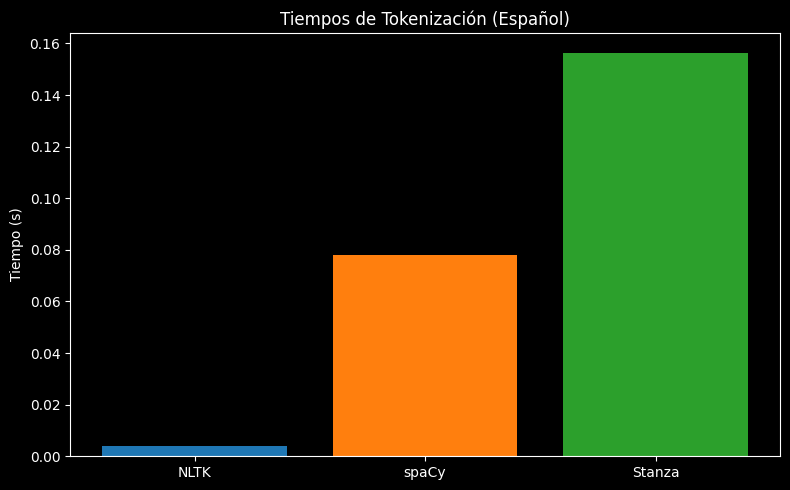

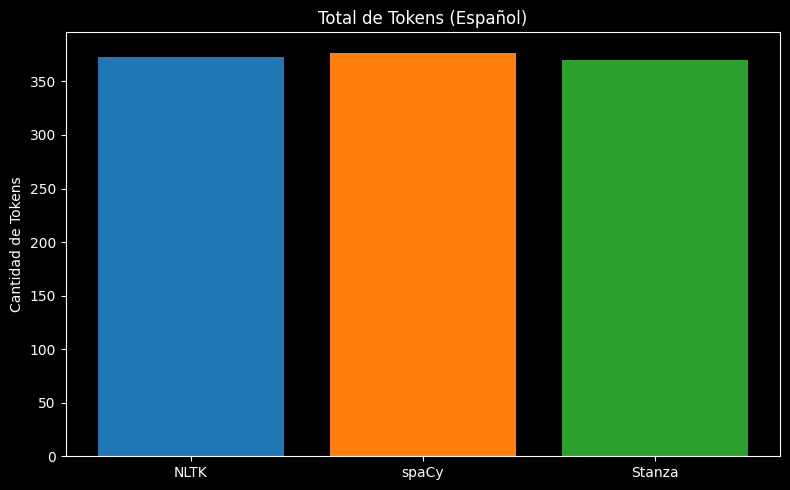

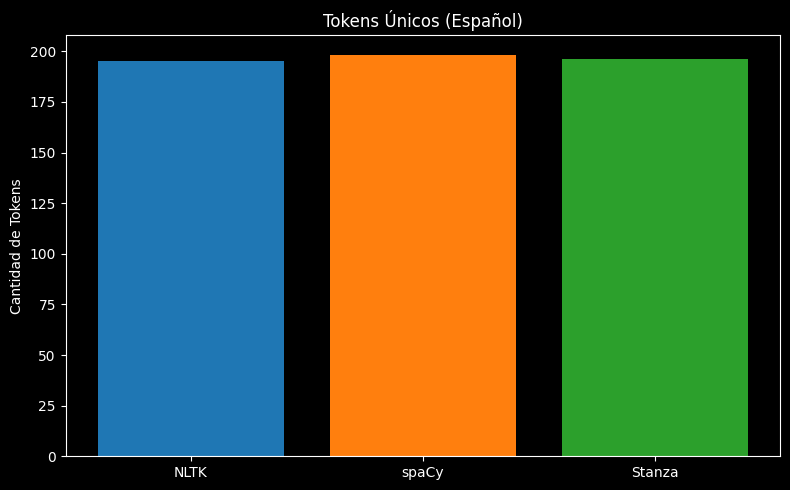

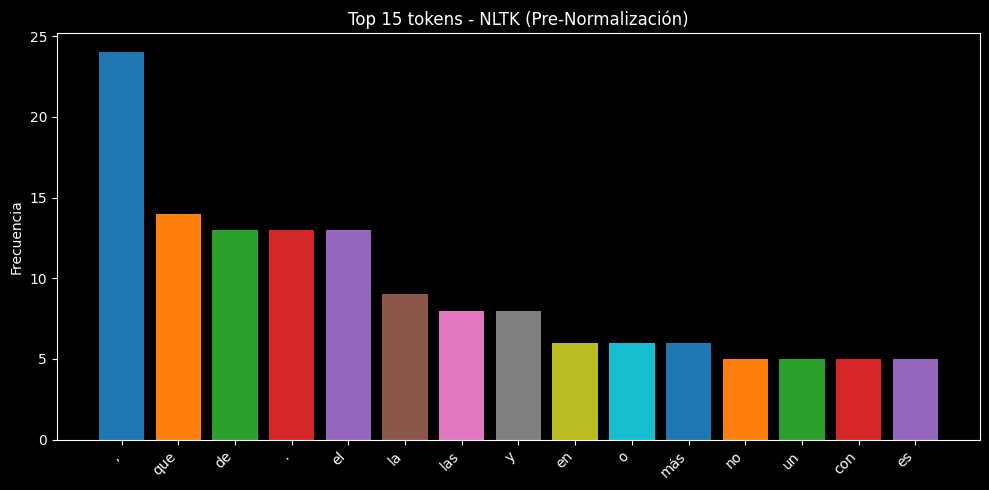

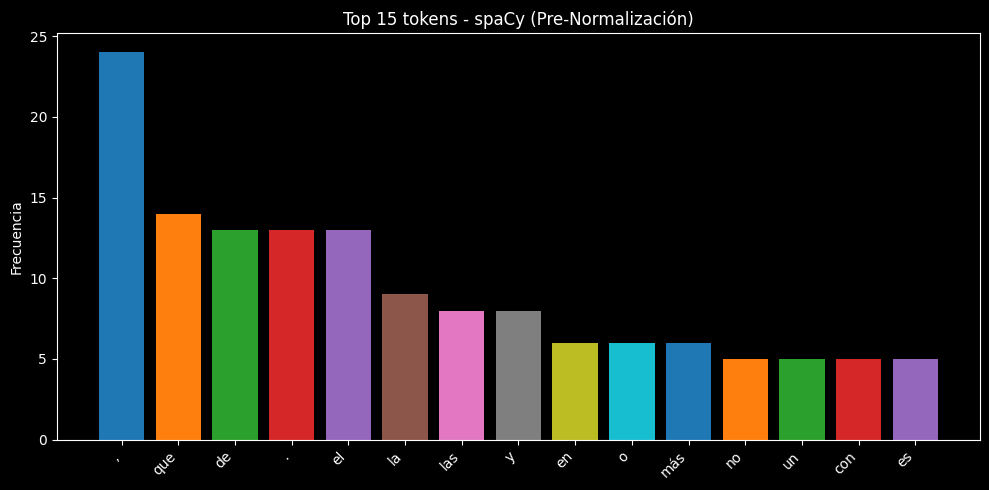

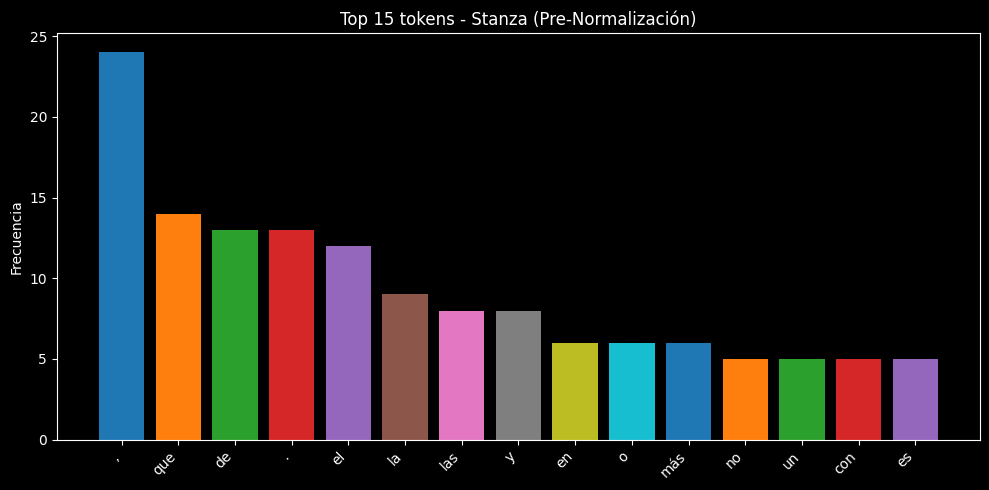

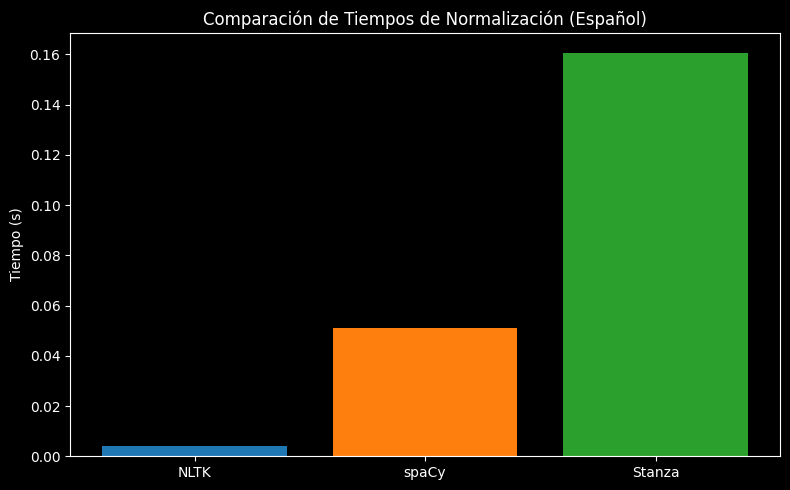

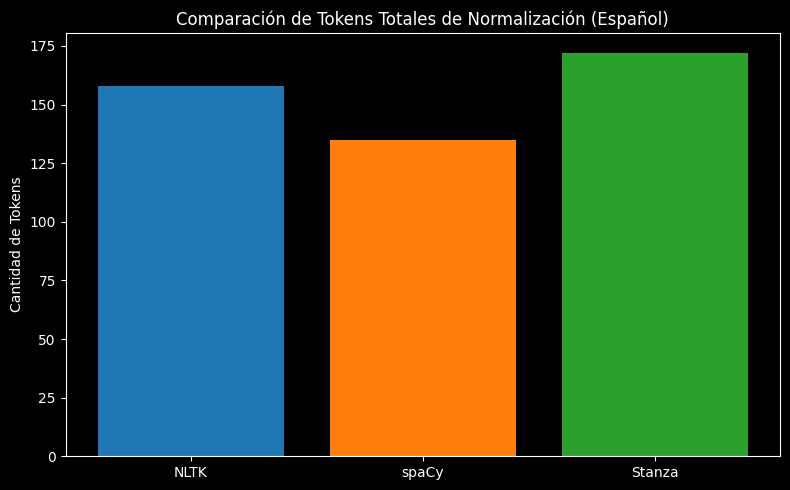

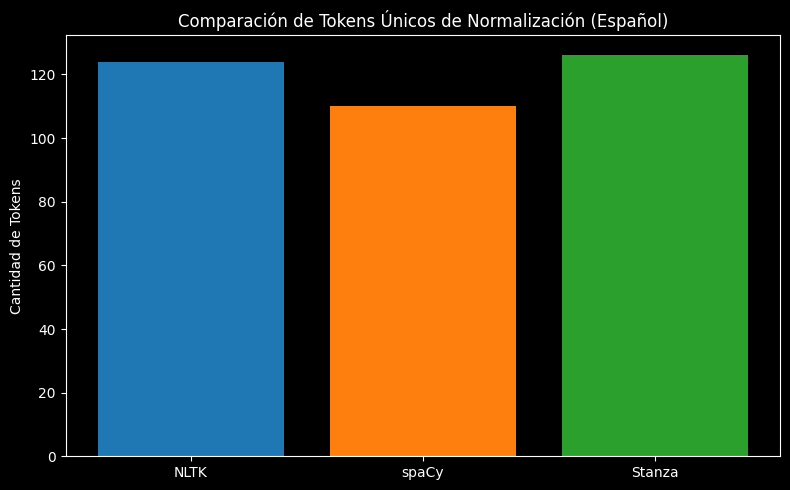

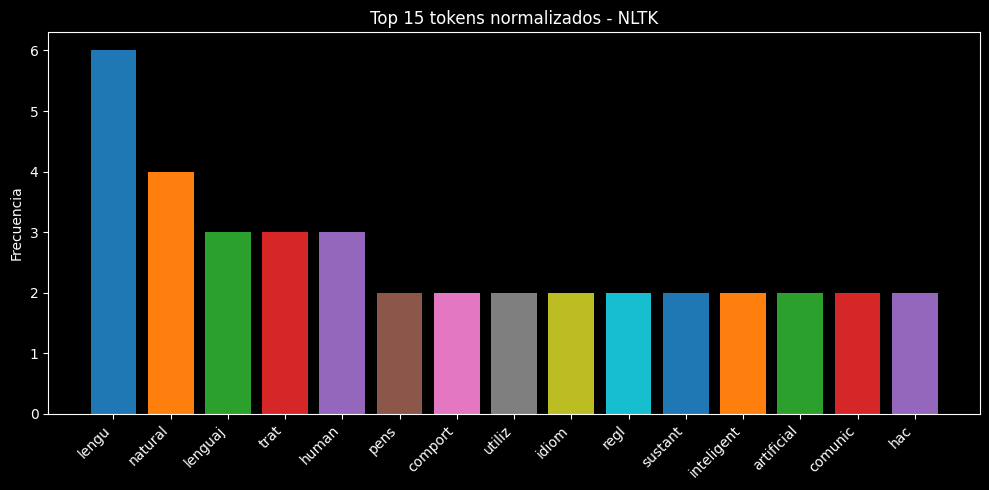

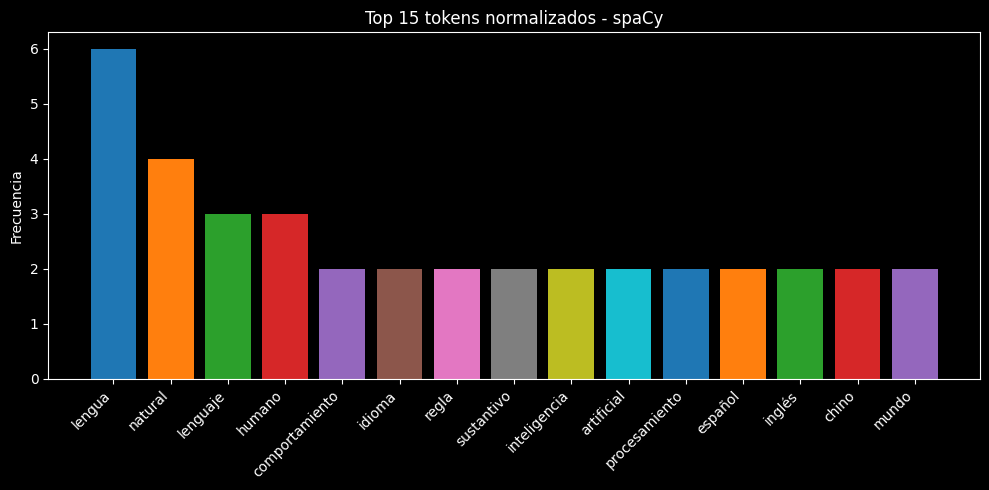

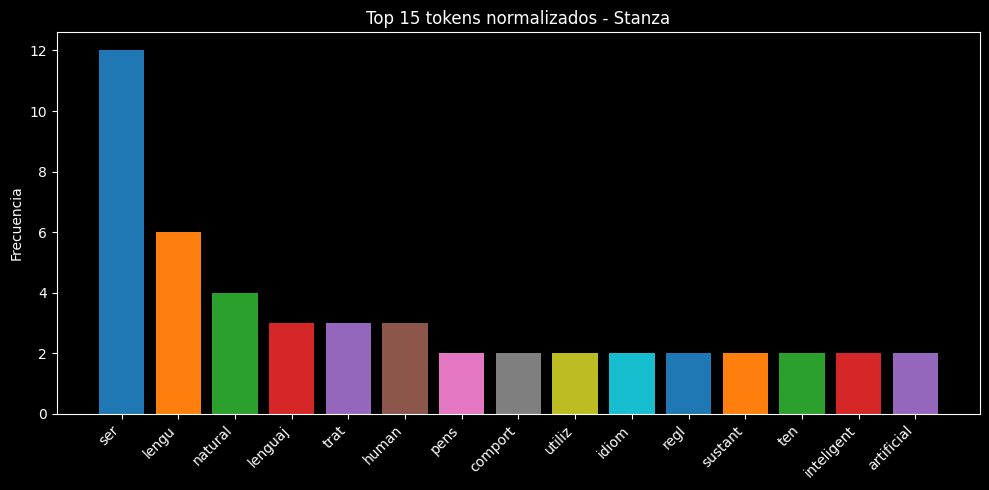

In [37]:
modulos_es = list(resultados_ex_es.keys())

# Comparación de tiempos (tokenización) para español
plot_comparison(modulos_es, [resultados_ex_es[m]['tiempo'] for m in modulos_es],
                "Tiempos de Tokenización (Español)", "Tiempo (s)")
# Comparación de tokens totales (tokenización) para español
plot_comparison(modulos_es, [resultados_ex_es[m]['total'] for m in modulos_es],
                "Total de Tokens (Español)", "Cantidad de Tokens")
# Comparación de tokens únicos (tokenización) para español
plot_comparison(modulos_es, [resultados_ex_es[m]['unicos'] for m in modulos_es],
                "Tokens Únicos (Español)", "Cantidad de Tokens")
# Histogramas de los 15 tokens más frecuentes antes de la normalización para español
for modulo in procesos_es.keys():
    plot_top_tokens(resultados_ex_es[modulo]['frecuencia'],
                    f"Top 15 tokens - {modulo} (Pre-Normalización)")

# Comparación de tiempos de normalización para español
plot_comparison(modulos_es, [resultados_norm_es[m]['tiempo'] for m in modulos_es],
                "Comparación de Tiempos de Normalización (Español)", "Tiempo (s)")
# Comparación de tokens totales tras la normalización para español
plot_comparison(modulos_es, [resultados_norm_es[m]['total'] for m in modulos_es],
                "Comparación de Tokens Totales de Normalización (Español)", "Cantidad de Tokens")
# Comparación de tokens únicos tras la normalización para español
plot_comparison(modulos_es, [resultados_norm_es[m]['unicos'] for m in modulos_es],
                "Comparación de Tokens Únicos de Normalización (Español)", "Cantidad de Tokens")

# Graficar top 15 tokens normalizados para cada módulo (Español)
for modulo in modulos_es:
    plot_top_tokens(resultados_norm_es[modulo]['frecuencia'],
                    f"Top 15 tokens normalizados - {modulo}")


## Discusión y Conclusiones

- **Tokenización vs. Normalización:**  
  En el análisis exploratorio se observa cómo cada módulo tokeniza el texto original, generando diferencias en el total y en la diversidad de tokens. Tras aplicar la normalización, se reduce la variabilidad (por ejemplo, la conversión a minúsculas, la eliminación de puntuación y stop words) lo que suele derivar en un menor número de tokens únicos y una frecuencia de palabras más concentrada.

- **Efecto de las Técnicas de Normalización:**  
  - *Conversión a minúsculas y eliminación de caracteres no alfabéticos* aseguran que palabras con diferentes mayúsculas se traten de forma unificada, reduciendo la dispersión léxica.  
  - *Stop words y filtrado de tokens cortos* eliminan palabras de poco significado, lo que puede mejorar el análisis de contenido y la identificación de términos clave.  
  - *Stemming y lematización* simplifican las variantes morfológicas, aunque pueden producir resultados distintos según el módulo y el idioma (por ejemplo, en español el lematizador de spaCy suele ser más robusto que el enfoque basado en stemming).

- **Comparación entre Módulos:**  
  Cada herramienta tiene sus particularidades:
  - **NLTK** ofrece una implementación clásica y flexible, pero puede requerir mayor configuración (y el uso combinado de técnicas como stemming y lematización).
  - **spaCy** proporciona un pipeline optimizado que integra tokenización y lematización de forma nativa, lo que a menudo se traduce en una mayor consistencia en los resultados.
  - **Stanza** resulta muy interesante para la lematización y procesamiento estructurado, aunque en algunos casos se recurre a técnicas adicionales (como el uso de un stemmer) para equiparar los resultados.

Esta comparación detallada permite apreciar cómo cada técnica de normalización influye en el documento final, facilitando la elección del módulo que mejor se adapte a las necesidades específicas de análisis de corpus en distintos idiomas.

Explicar por qué sale la palabra ser en stanza